In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [ ]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [ ]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [ ]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    
    unique_list = np.unique(label_array)
    entropy= 0

    for k in unique_list:
        proportion = sum(label_array==k) / len(label_array)
        entropy += - proportion * np.log2(proportion)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    

    unique_list = np.unique(label_array)
    gini=0
    
    for k in unique_list:
        proportion = sum(label_array==k) / len(label_array)
        gini += proportion * (1-proportion)
  
    return gini

In [ ]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False
        self.left = None
        self.right = None
        self.split_id = None
        self.split_point=None
        self.split_value = None 
        self.loss = None

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
       

        if self.depth == self.max_depth or x.shape[0] <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        else: 
            self.split_id , self.split_point, self.split_value= self.find_best_feature_split(x, y)

            if self.split_id == None:
                self.value =  self.leaf_value_estimator(y)
                self.is_leaf = True
                return self 

            else:

                left_fit_y=[]
                left_fit_x=[]

                right_fit_y=[]
                right_fit_x=[]

                for ind in range(x.shape[0]):
                  if x[ind][self.split_id]<=self.split_value:
                    left_fit_x.append(x[ind])
                    left_fit_y.append(y[ind])

                  else:
                    right_fit_x.append(x[ind])
                    right_fit_y.append(y[ind])

                left_fit_x=np.array(left_fit_x)
                left_fit_y=np.array(left_fit_y).reshape(-1,1)

                right_fit_x=np.array(right_fit_x)
                right_fit_y=np.array(right_fit_y).reshape(-1,1)

                if len(left_fit_y)<=self.min_sample:
                  self.is_leaf=True
                  self.value = self.leaf_value_estimator(y)
                  return self
                if len(right_fit_y)<=self.min_sample:
                  self.is_leaf=True
                  self.value = self.leaf_value_estimator(y)
                  return self

                self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, self.min_sample, self.max_depth)
                self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,self.depth+1, self.min_sample, self.max_depth)

                self.left.fit(left_fit_x,left_fit_y)
                self.right.fit(right_fit_x, right_fit_y)
                 

            
        
        

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        
        training_data = np.concatenate((x_node,y_node),axis=1)
        best_loss = self.split_loss_function(y_node)
        training_data=np.array(sorted(training_data,key=lambda x:x[feature_id]))
        best_point=None
        split_value=None

        for point in range(x_node.shape[0]):
            left_x = training_data[:point+1,:-1]
            right_x = training_data[point+1:,:-1]
            left_y = training_data[:point+1,-1].reshape(-1,1)
            right_y = training_data[point+1:,-1].reshape(-1,1)

            
            total_loss=(len(left_y)*self.split_loss_function(left_y)+len(right_y)*self.split_loss_function(right_y))/(len(left_y)+len(right_y))
            
            
            if total_loss < best_loss:
                
                split_value = 0.5 * (training_data[point,feature_id]+training_data[point+1,feature_id]) 
                best_loss = total_loss
                best_point=point
              
        
        return best_point, best_loss, split_value

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''


        training_data = np.concatenate((x_node,y_node),axis=1)
        best_loss = compute_entropy(y_node)
        feature_split_id = None
        split_value=None
        split_point=None

        for feature_id in range(x_node.shape[1]):
          split_point_id,total_loss_id,split_value_id=self.find_best_split(x_node,y_node,feature_id)

          if total_loss_id<best_loss:
            best_loss=total_loss_id
            feature_split_id=feature_id
            split_point=split_point_id
            split_value=split_value_id
                 

        return feature_split_id,split_point,split_value

        


    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

In [ ]:
def most_common_label(y):
    '''
    Find most common label
    '''

    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    
    return label

# Decision Tree Classifier

In [ ]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

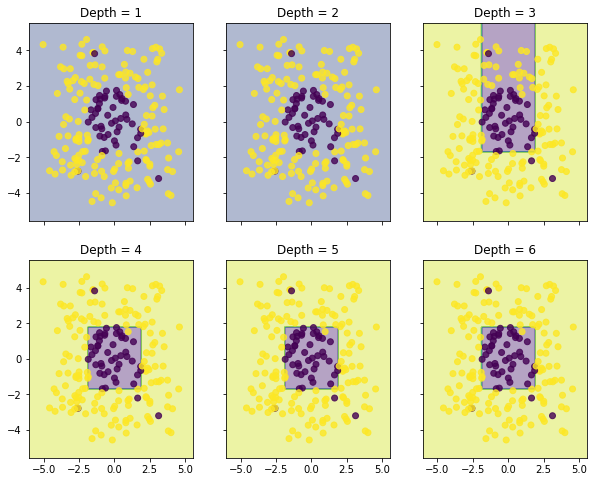

In [ ]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

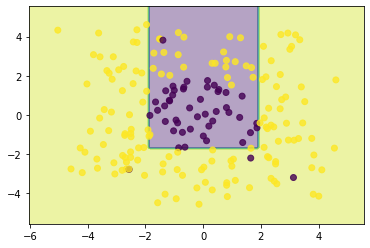

In [ ]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

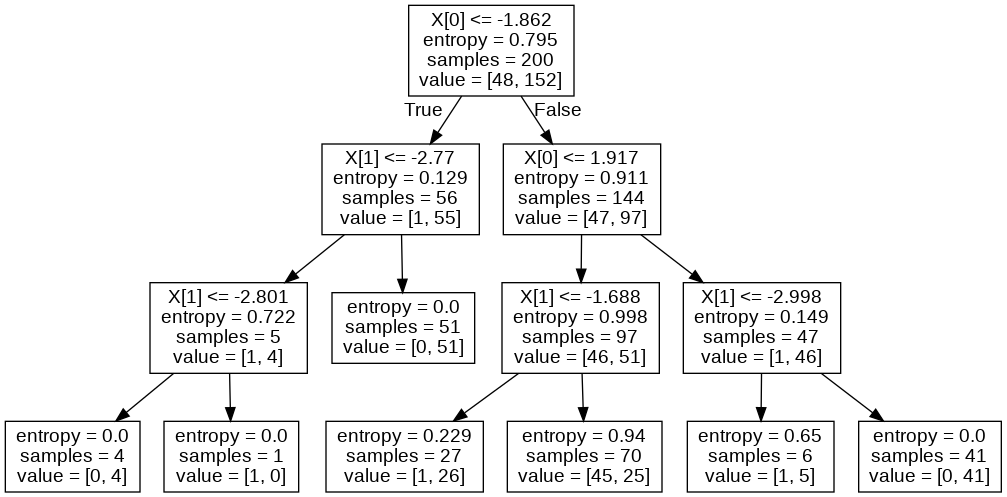

In [ ]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [ ]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    median = np.median(y)
    list1 = []
    for element in y:
      list1.append(np.abs(element[0]-median))
    
    array1 = np.array(list1)
    mae=np.mean(array1)
    
    return mae

In [ ]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


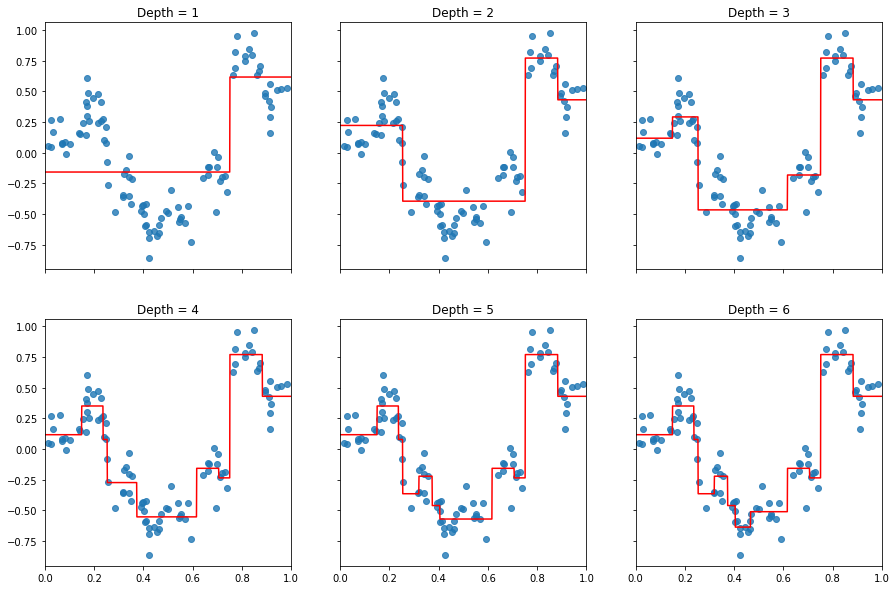

In [ ]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

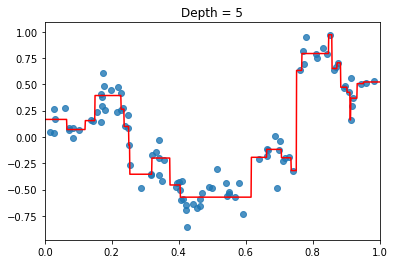

In [ ]:
# DecisionTreeRegressor(criterion=, max_depth=, min_samples_split=)


# Gradient Boosting Method

In [ ]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [ ]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.h_1 = None
        

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        
        f_0 = 0
        residuals = self.pseudo_residual_func(train_target.flatten(),0)
        self.h_1 = DecisionTreeRegressor(criterion='squared_error', max_depth = self.max_depth, min_samples_leaf = self.min_sample)
        self.h_1.fit(X=train_data, y=residuals)
        self.estimators.append(self.h_1)
        
        for i in range(self.n_estimator):
            current_prediction = self.learning_rate*self.h_1.predict(train_data)

            for estimator in range(len(self.estimators)):
              current_prediction += self.learning_rate * self.estimators[estimator].predict(train_data)
        
            residuals = self.pseudo_residual_func(train_target.flatten(),current_prediction)
          
            h_current = DecisionTreeRegressor(criterion='squared_error', max_depth = self.max_depth, min_samples_leaf = self.min_sample)
            h_current.fit(train_data,residuals)
            self.estimators.append(h_current)


    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        
        test_predict = 0
        for estimator in range(len(self.estimators)):
          test_predict+=self.learning_rate * self.estimators[estimator].predict(test_data)
        
        return test_predict


# 1-D GBM visualization - KRR data

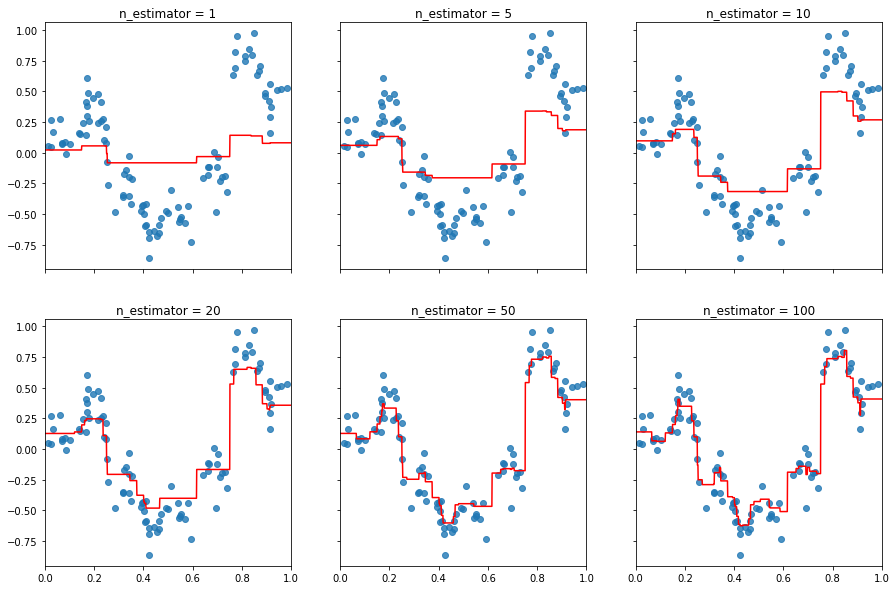

In [ ]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

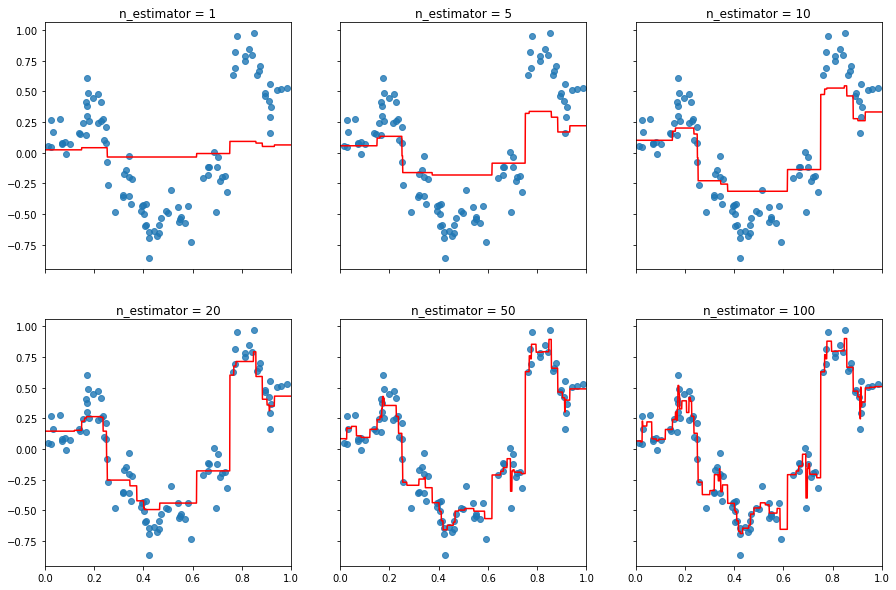

In [ ]:
###GradientBoostingRegressor
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = GradientBoostingRegressor(n_estimators=i, criterion='squared_error', 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [ ]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [ ]:
def accuracy(y,y_prediction):
  accuracy = sum(y == y_prediction)/len(y)
  return accuracy


In [ ]:
##train 
estimator_list = [2,5,10,50,100,200]
accuracy_array=np.zeros((1,6)).flatten()
accuracy_array_test=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    clf_ = GradientBoostingClassifier(loss='deviance',max_depth=3,n_estimators=estimator_list[i])
    clf_.fit(X_train,y_train)
    accuracy_array[i]= clf_.score(X_train,y_train)
    accuracy_array_test[i] = clf_.score(X_test,y_test)




In [ ]:
##test
estimator_list = [2,5,10,50,100,200]
accuracy_array_test=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    
    reg = GradientBoostingClassifier(loss='deviance',max_depth=3,n_estimators=estimator_list[i])
    reg.fit(X_test,y_test)
    prediction1 = reg.predict(X_test)

    accuracy_array_test[i]=accuracy(y_test,prediction1)

Text(0.5, 1.0, 'GradientBoostingClassifier')

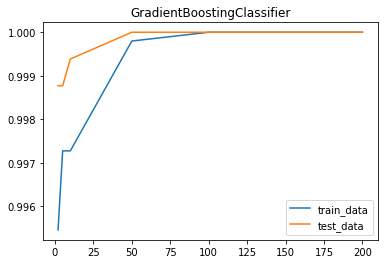

In [ ]:
plt.plot(estimator_list,accuracy_array,label='train_data')
plt.plot(estimator_list,accuracy_array_test,label='test_data')
plt.legend()
plt.title('GradientBoostingClassifier')

In [ ]:
##train 
estimator_list = [2,5,10,50,100,200]
accuracy_array=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    
    reg = RandomForestClassifier(criterion='entropy',max_depth=3,n_estimators=estimator_list[i])
    reg.fit(X_train,y_train)
    prediction = reg.predict(X_train)

    accuracy_array[i]=accuracy(y_train,prediction)

In [ ]:
##test
estimator_list = [2,5,10,50,100,200]
accuracy_array_test=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    
    reg = RandomForestClassifier(criterion='entropy',max_depth=3,n_estimators=estimator_list[i])
    reg.fit(X_test,y_test)
    prediction1 = reg.predict(X_test)

    accuracy_array_test[i]=accuracy(y_test,prediction1)

Text(0.5, 1.0, 'RandomForestClassifier')

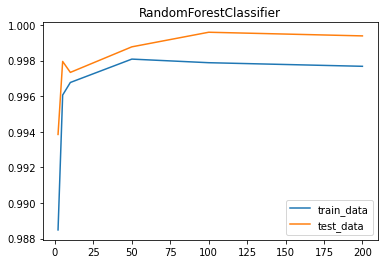

In [ ]:
plt.plot(estimator_list,accuracy_array,label='train_data')
plt.plot(estimator_list,accuracy_array_test,label='test_data')
plt.legend()
plt.title('RandomForestClassifier')

In [ ]:
###Random forests is a bagging model, which belongs to parallel ensemble methods that can combile multiple weak decision trees into a more powerful single tree model. The estimation of random forests can reduce variance without changing bias of the model. And when constructing each tree node, we should restrict choice of splitting variable to a randomly chosen subset of features.

In [ ]:
##train 
estimator_list = [2,5,10,50,100,200]
accuracy_array=np.zeros((1,6)).flatten()
accuracy_array_test=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    clf_ = GradientBoostingClassifier(loss='deviance',max_depth=3,n_estimators=estimator_list[i])
    clf_.fit(X_train,y_train)
    accuracy_array[i]= clf_.score(X_train,y_train)
    accuracy_array_test[i] = clf_.score(X_test,y_test)

Text(0.5, 1.0, 'GradientBoostingClassifier')

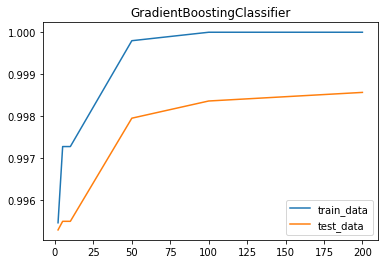

In [ ]:
plt.plot(estimator_list,accuracy_array,label='train_data')
plt.plot(estimator_list,accuracy_array_test,label='test_data')
plt.legend()
plt.title('GradientBoostingClassifier')

In [ ]:
##train 
estimator_list = [2,5,10,50,100,200]
accuracy_array=np.zeros((1,6)).flatten()
accuracy_array_test=np.zeros((1,6)).flatten()

for i in range(len(estimator_list)):
    clf_ = RandomForestClassifier(criterion='entropy',max_depth=3,n_estimators=estimator_list[i])
    clf_.fit(X_train,y_train)
    accuracy_array[i]= clf_.score(X_train,y_train)
    accuracy_array_test[i] = clf_.score(X_test,y_test)


Text(0.5, 1.0, 'RandomForestClassifier')

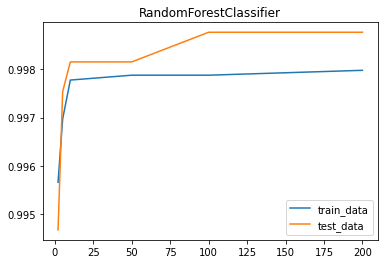

In [ ]:
plt.plot(estimator_list,accuracy_array,label='train_data')
plt.plot(estimator_list,accuracy_array_test,label='test_data')
plt.legend()
plt.title('RandomForestClassifier')

Increase the number of trees we use in bagging does not lead to overfitting. 